In [1]:
import datetime
print(f"Last updated on {datetime.date.today()}.")

Last updated on 2025-11-04.


# Direct inversion algorithm for reference state computation (Neal et al 2023 GRL)

This notebook computes LWA and reference states from the same dataset as in `demo_script_for_nh2018.ipynb` but use the new boundary conditions outlined in NHN22:

Neal, E., Huang, C. S., & Nakamura, N. (2022). [The 2021 Pacific Northwest heat wave and associated blocking: meteorology and the role of an upstream cyclone as a diabatic source of wave activity.](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021GL097699) *Geophysical Research Letters*, 49(8), e2021GL097699.

See the code under **Additional parameters needed to switch to NHN22 boundary conditions** for additional parameters needed to compute reference states with NHN22 boundary conditions.

---

From release `v0.7.0`, users can choose the version of boundary conditions to compute reference states via the child class of `QGField`. To compute reference states using boundary condition in NHN22 with a dataset of $1^\circ\times1^\circ$ grid resolution, one could initialized the corresponding `QGField` child class:

```python
QGFieldNHN22(xlon, ylat, plev, uu, vv, tt, eq_boundary_index=5)
```
which corresponds to an equatorward boundary at $5^\circ$N.

This notebook is using a dataset of $1.5^\circ\times1.5^\circ$ grid resolution such that `eq_boundary_index=3` refers to an equatorward boundary at $4.5^\circ$N.

---

Please [raise an issue in the GitHub repo](https://github.com/csyhuang/hn2016_falwa/issues) or contact Clare S. Y. Huang (csyhuang@uchicago.edu) if you have any questions or suggestions regarding the package.

In [2]:
import numpy as np
import xarray as xr
from numpy import dtype
from math import pi
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
from falwa.oopinterface import QGFieldNHN22
import datetime as dt
import falwa
print(falwa.__version__)

2.2.2


## Sample data

The netCDF dataset used below can be downloaded from [Clare's Dropbox folder](https://www.dropbox.com/scl/fo/b84pwlr7zzsndq8mpthd8/h/notebooks/nh2018_science?dl=0&subfolder_nav_tracking=1). It is retrieved from:
https://cds.climate.copernicus.eu/#!/home

In [3]:
u_file = xr.open_dataset('2005-01-23_to_2005-01-30_u.nc')
v_file = xr.open_dataset('2005-01-23_to_2005-01-30_v.nc')
t_file = xr.open_dataset('2005-01-23_to_2005-01-30_t.nc')
ntimes = u_file.valid_time.size
time_array = u_file.valid_time

In [4]:
u_file

<xarray.Dataset>
Dimensions:         (valid_time: 32, pressure_level: 37, latitude: 121,
                     longitude: 240)
Coordinates:
    number          int64 ...
  * valid_time      (valid_time) datetime64[ns] 2005-01-23 ... 2005-01-30T18:...
  * pressure_level  (pressure_level) float64 1e+03 975.0 950.0 ... 3.0 2.0 1.0
  * latitude        (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude       (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    expver          (valid_time) <U4 ...
Data variables:
    u               (valid_time, pressure_level, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-26T21:32 GRIB to CDM+CF via cfgrib-0.9.1...

## Load the dimension arrays
In this version, the `QGField` object takes only:
- latitude array in degree ascending order, and 
- pressure level in hPa in decending order (from ground to aloft).

In [5]:
xlon = u_file.longitude.values

# latitude has to be in ascending order
ylat = u_file.latitude.values
if np.diff(ylat)[0]<0:
    print('Flip ylat.')
    ylat = ylat[::-1]

# pressure level has to be in descending order (ascending height)
plev = u_file.pressure_level.values
if np.diff(plev)[0]>0:
    print('Flip plev.')    
    plev = plev[::-1]

nlon = xlon.size
nlat = ylat.size
nlev = plev.size

Flip ylat.


In [6]:
clat = np.cos(np.deg2rad(ylat))     # cosine latitude
p0 = 1000.                          # surface pressure [hPa]
kmax = 49                           # number of grid points for vertical extrapolation (dimension of height)
dz = 1000.                          # differential height element
height = np.arange(0,kmax)*dz       # pseudoheight [m]
dphi = np.diff(ylat)[0]*pi/180.     # differential latitudinal element
dlambda = np.diff(xlon)[0]*pi/180.  # differential latitudinal element
hh = 7000.                          # scale height
cp = 1004.                          # heat capacity of dry air
rr = 287.                           # gas constant
omega = 7.29e-5                     # rotation rate of the earth
aa = 6.378e+6                       # earth radius
prefactor = np.array([np.exp(-z/hh) for z in height[1:]]).sum() # integrated sum of density from the level
                                                                #just above the ground (z=1km) to aloft
npart = nlat                        # number of partitions to construct the equivalent latitude grids
maxits = 100000                     # maximum number of iteration in the SOR solver to solve for reference state
tol = 1.e-5                         # tolerance that define convergence of solution
rjac = 0.95                         # spectral radius of the Jacobi iteration in the SOR solver.              
jd = nlat//2+1                      # (one plus) index of latitude grid point with value 0 deg
                                    # This is to be input to fortran code. The index convention is different.

## Set the level of pressure and the timestamp to display below

In [7]:
tstamp = [dt.datetime(2005,1,23,0,0) + dt.timedelta(seconds=6*3600) * tt for tt in range(ntimes)]
plev_selected = 10 # selected pressure level to display
tstep_selected = 0

## Additional parameters to compute reference state from NHN22 boundary conditions

This dataset has $1.5^\circ$ latitude resolution. `eq_boundary_index = 3` refers to an equatorward boundary at $4.5^\circ$N

In [8]:
eq_boundary_index = 3

## Loop through the input file and store all the computed quantities in a netCDF file

Do scipy interpolation
 nlon, nlat, kmax, jd
         240         121          49          61
num of nan in fawa: 2.
line 748: ncforce is None
 nd:           61 , jb:            3
 nd:           61 , jb:            3
 nd:           61 , jb:            3
 nd:           61 , jb:            3


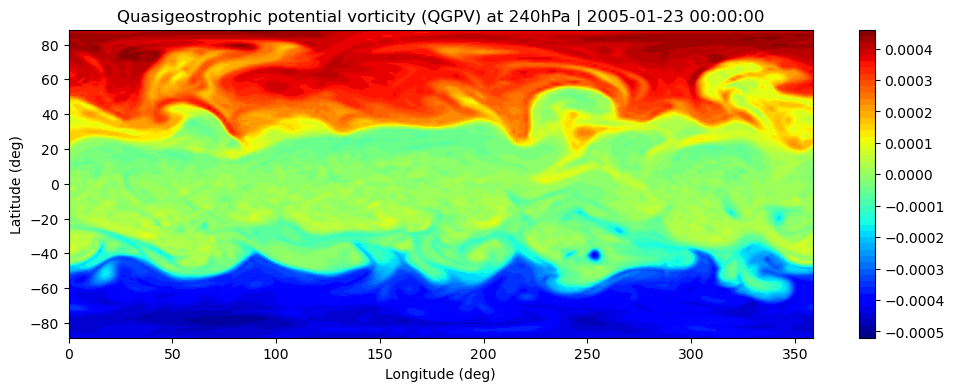

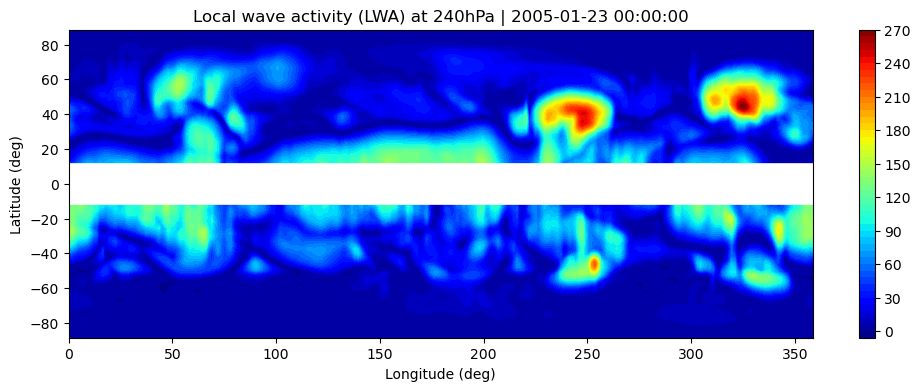

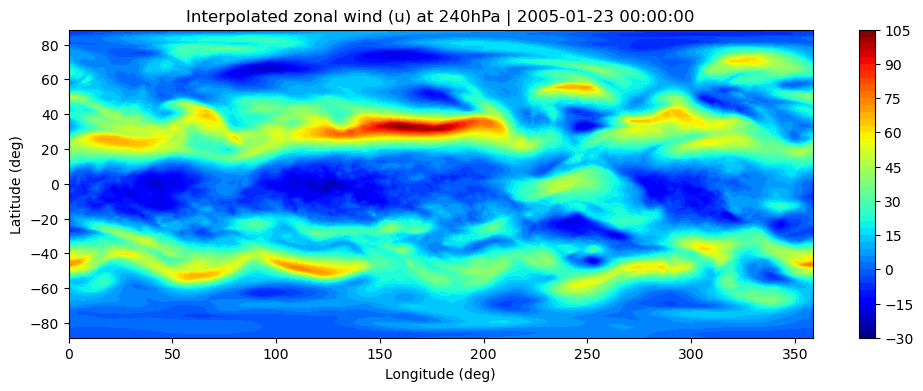

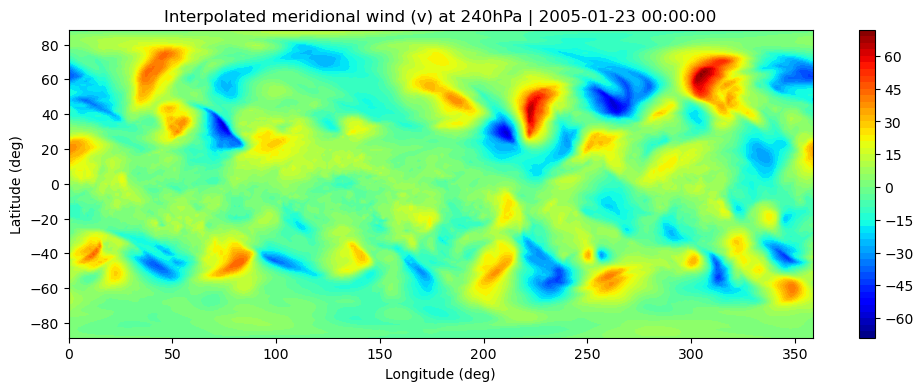

Max(val):0.0005924048306947067, Min(val):-0.0006395894622982084


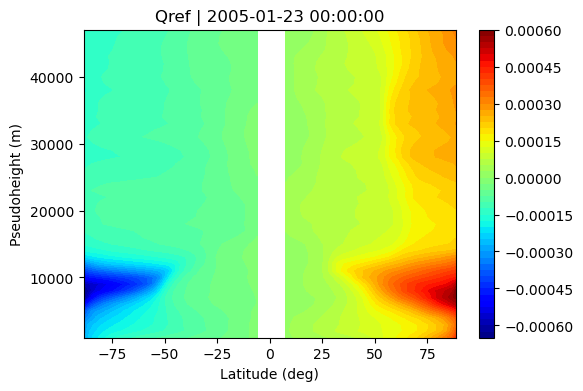

Max(val):93.4193115234375, Min(val):-43.19191360473633


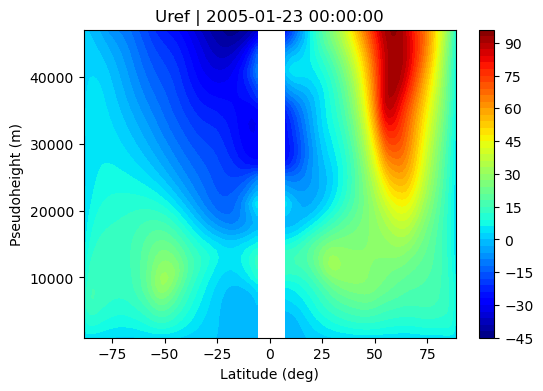

Max(val):1887.701904296875, Min(val):225.5102996826172


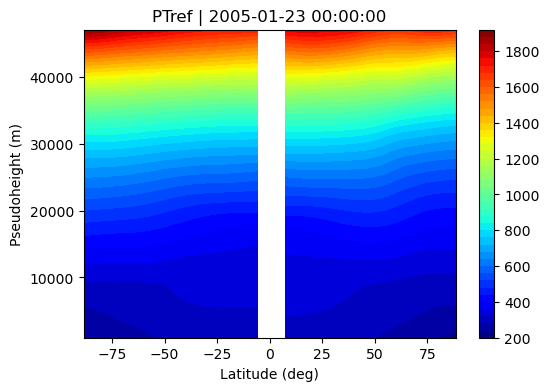

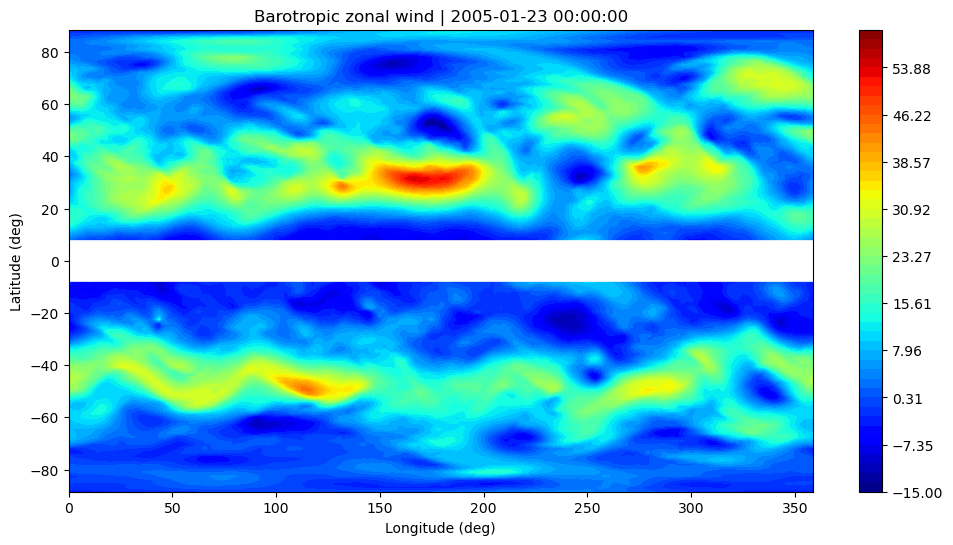

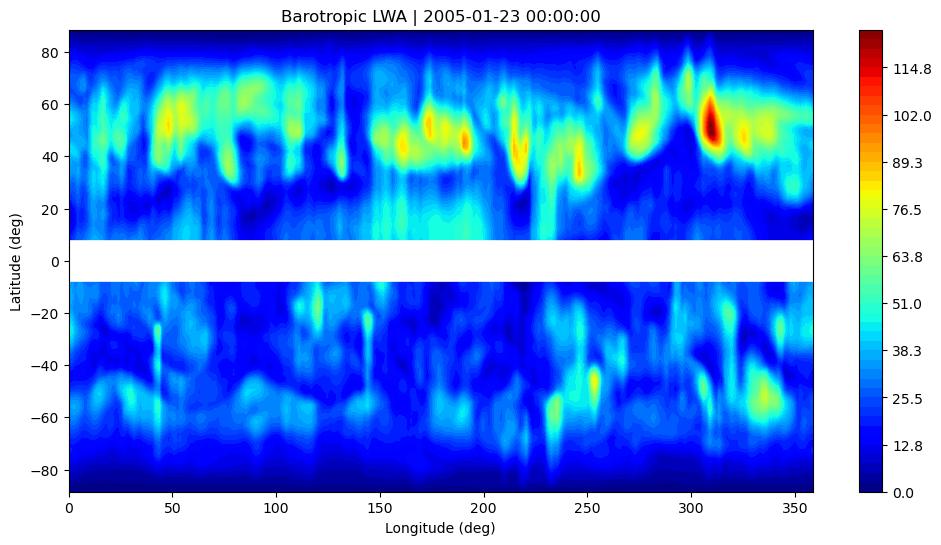

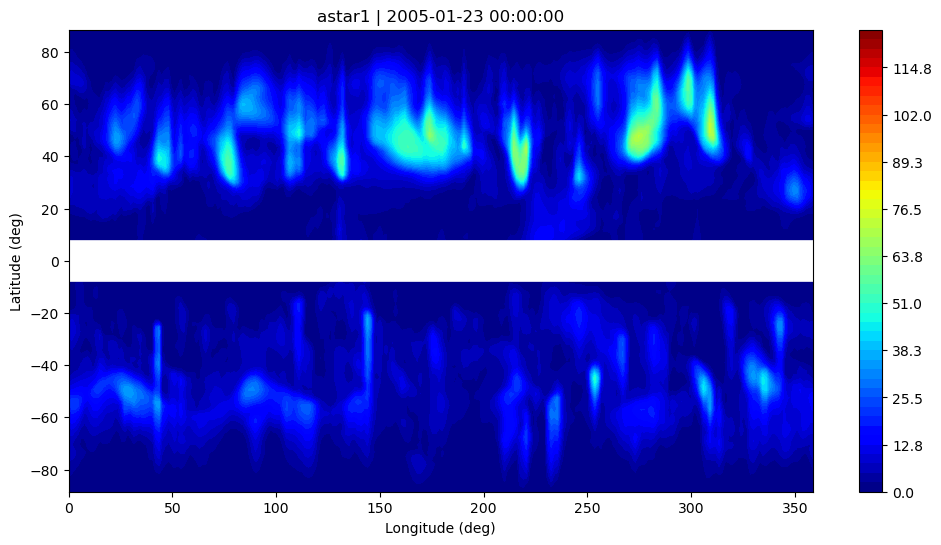

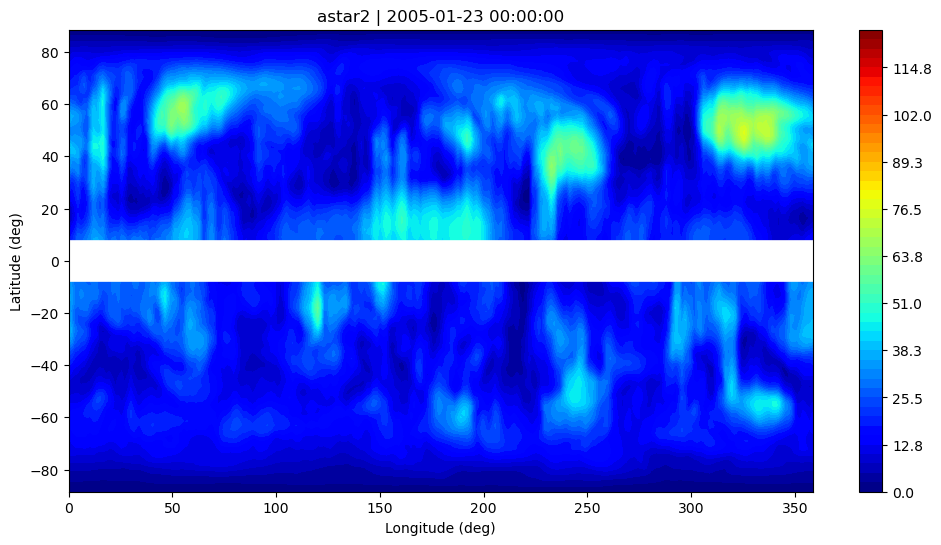

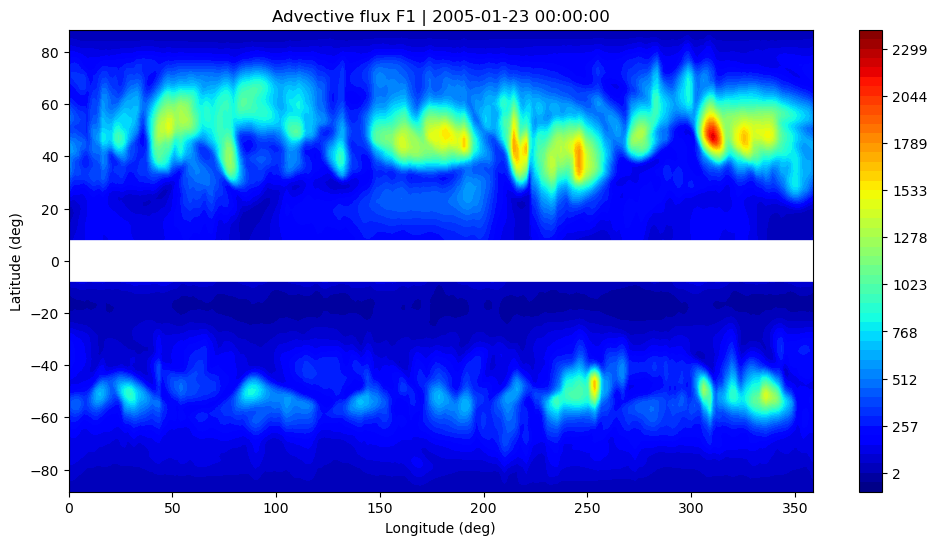

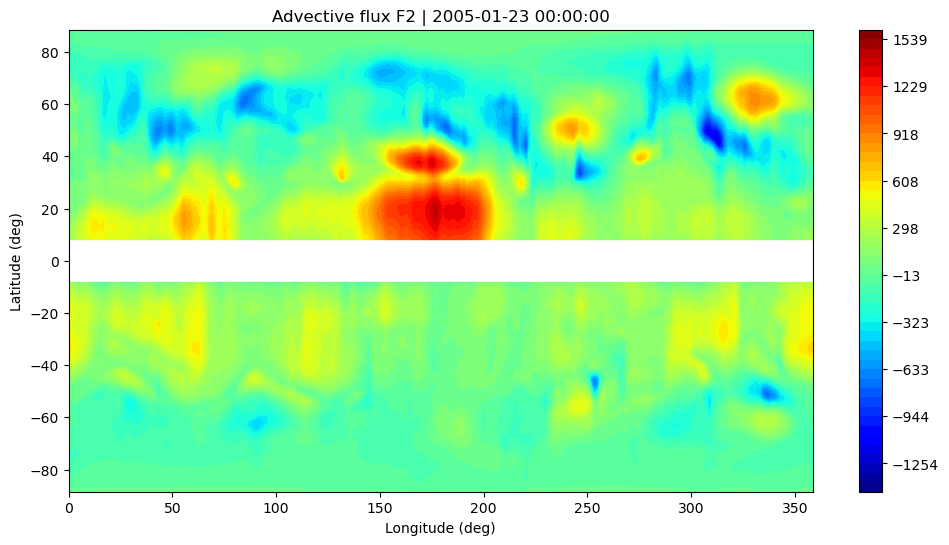

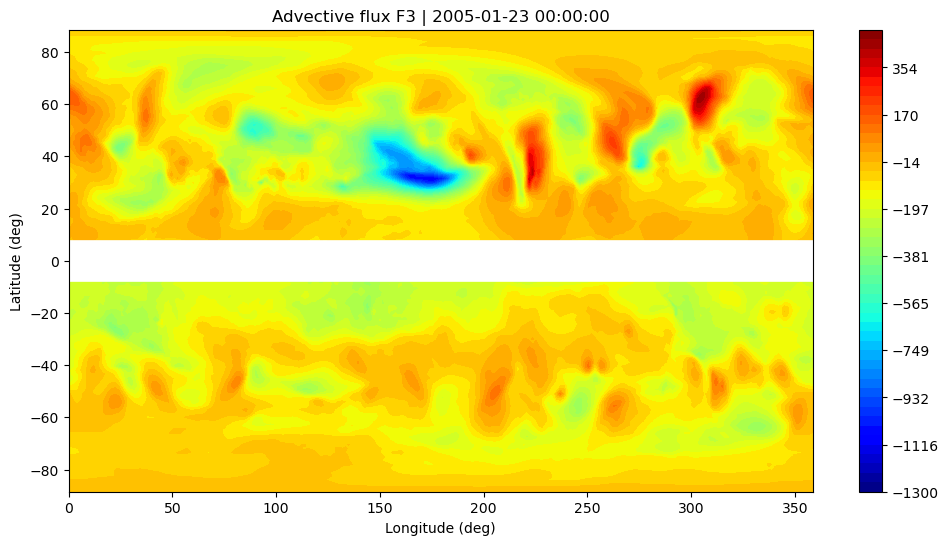

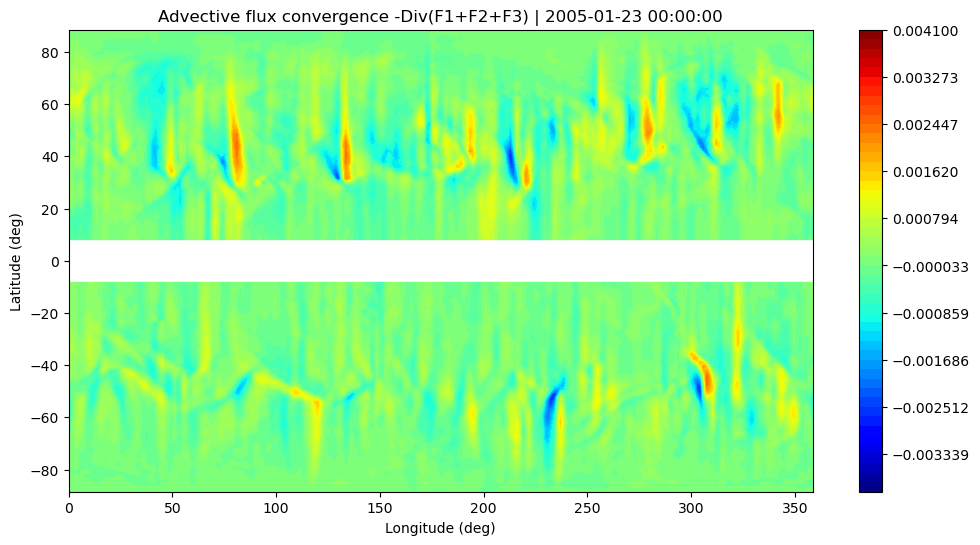

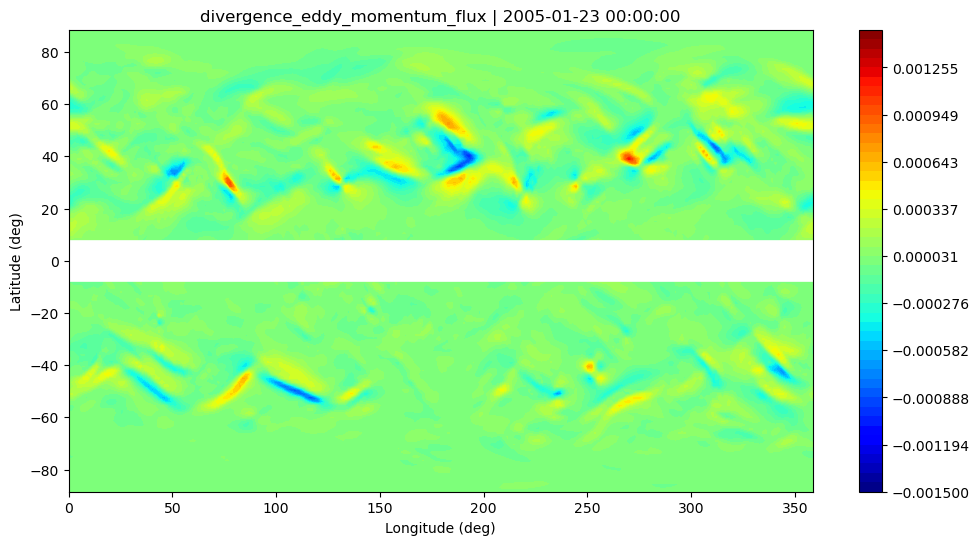

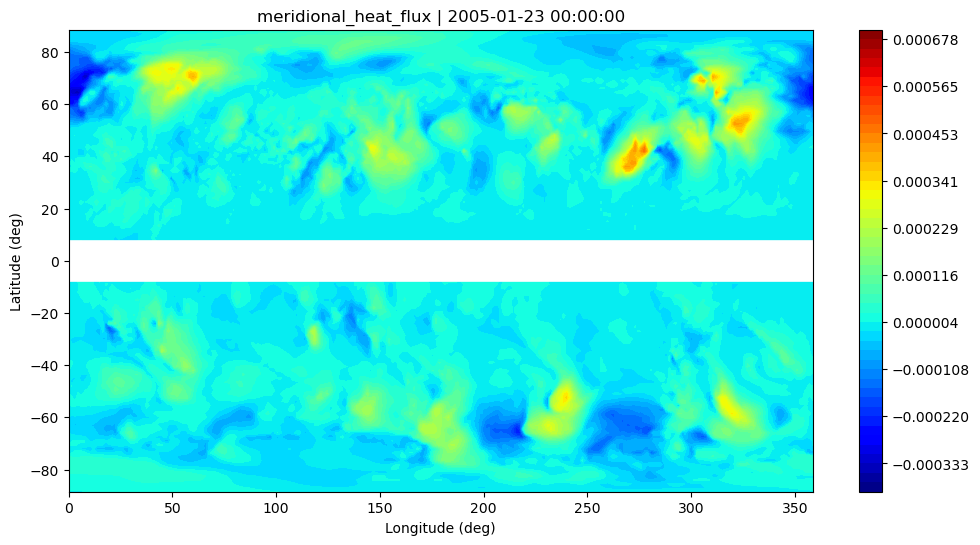

In [9]:
tstep=0
uu = u_file.variables['u'][tstep, :, ::-1, :].data
vv = v_file.variables['v'][tstep, :, ::-1, :].data
tt = t_file.variables['t'][tstep, :, ::-1, :].data

qgfield_object = QGFieldNHN22(
    xlon, ylat, plev, uu, vv, tt, eq_boundary_index=eq_boundary_index, northern_hemisphere_results_only=False)
equator_idx = qgfield_object.equator_idx

qgfield_object.interpolate_fields(return_named_tuple=False)

qgfield_object.compute_reference_states(return_named_tuple=False)

qgfield_object.compute_lwa_and_barotropic_fluxes(return_named_tuple=False)

qgfield_object.compute_layerwise_lwa_fluxes()


# === Below demonstrate another way to access the computed variables ===
# 3D Variables that I would choose one pressure level to display
variables_3d = [
    (qgfield_object.qgpv, 'Quasigeostrophic potential vorticity (QGPV)'),
    (qgfield_object.lwa, 'Local wave activity (LWA)'),
    (qgfield_object.interpolated_u, 'Interpolated zonal wind (u)'),
    (qgfield_object.interpolated_v, 'Interpolated meridional wind (v)')]

# Reference states to be displayed on y-z plane
variables_yz = [
    (qgfield_object.qref, 'Qref'),
    (qgfield_object.uref, 'Uref'),
    (qgfield_object.ptref, 'PTref')]

# Vertically averaged variables to be displayed on x-y plane
variables_xy = [
    (qgfield_object.u_baro, 'Barotropic zonal wind'),
    (qgfield_object.lwa_baro, 'Barotropic LWA'),
    (np.swapaxes(qgfield_object._barotropic_flux_terms_storage.astar1_baro, 1, 0), 'astar1'),
    (np.swapaxes(qgfield_object._barotropic_flux_terms_storage.astar2_baro, 1, 0), 'astar2'),
    (qgfield_object.adv_flux_f1, 'Advective flux F1'),
    (qgfield_object.adv_flux_f2, 'Advective flux F2'),
    (qgfield_object.adv_flux_f3, 'Advective flux F3'),
    (qgfield_object.convergence_zonal_advective_flux, 'Advective flux convergence -Div(F1+F2+F3)'),
    (qgfield_object.divergence_eddy_momentum_flux, 'divergence_eddy_momentum_flux'),
    (qgfield_object.meridional_heat_flux, 'meridional_heat_flux')
]

# Plot 240 hPa of 3D-variables
for variable, name in variables_3d:
    plt.figure(figsize=(12,4))
    plt.contourf(xlon, ylat[1:-1], variable[plev_selected, 1:-1, :], 50, cmap='jet')
    if name=='Local wave activity (LWA)':
        plt.axhline(y=0, c='w', lw=30)
    plt.colorbar()
    plt.ylabel('Latitude (deg)')
    plt.xlabel('Longitude (deg)')
    plt.title(name + ' at 240hPa | ' + str(tstamp[tstep]))
    plt.show()

# Plot reference states
for variable, name in variables_yz:
    # Mask out equatorward region that is outside analysis boundary
    mask = np.zeros_like(variable)
    mask[:, equator_idx-eq_boundary_index-1:equator_idx+eq_boundary_index+1] = np.nan
    variable_masked = np.ma.array(variable, mask=mask)
    # Start plotting
    print(f"Max(val):{variable_masked[1:-1, 1:-1].max()}, Min(val):{variable_masked[1:-1, 1:-1].min()}")
    plt.figure(figsize=(6,4))
    plt.contourf(ylat[1:-1], height[1:-1], variable_masked[1:-1, 1:-1], 50, cmap='jet')
    plt.axvline(x=0, c='w', lw=2)
    plt.xlabel('Latitude (deg)')
    plt.ylabel('Pseudoheight (m)')
    plt.colorbar()
    plt.title(name + ' | ' + str(tstamp[tstep]))
    plt.show()

# Plot fluxes (color axies have to be fixed)
plt.figure(figsize=(12,6))
plt.contourf(xlon, ylat[1:-1], variables_xy[0][0][1:-1, :], np.linspace(-15, 60, 50), cmap='jet')
plt.axhline(y=0, c='w', lw=30)
plt.ylabel('Latitude (deg)')
plt.xlabel('Longitude (deg)')
plt.colorbar()
plt.title(variables_xy[0][1] + ' | ' + str(tstamp[tstep]))
plt.show()

plt.figure(figsize=(12,6))
plt.contourf(xlon, ylat[1:-1], variables_xy[1][0][1:-1, :], np.linspace(0, 125, 50), cmap='jet')
plt.axhline(y=0, c='w', lw=30)
plt.ylabel('Latitude (deg)')
plt.xlabel('Longitude (deg)')
plt.colorbar()
plt.title(variables_xy[1][1] + ' | ' + str(tstamp[tstep]))
plt.show()

plt.figure(figsize=(12,6))
plt.contourf(xlon, ylat[1:-1], variables_xy[2][0][1:-1, :], np.linspace(0, 125, 50), cmap='jet')
plt.axhline(y=0, c='w', lw=30)
plt.ylabel('Latitude (deg)')
plt.xlabel('Longitude (deg)')
plt.colorbar()
plt.title(variables_xy[2][1] + ' | ' + str(tstamp[tstep]))
plt.show()

plt.figure(figsize=(12,6))
plt.contourf(xlon, ylat[1:-1], variables_xy[3][0][1:-1, :], np.linspace(0, 125, 50), cmap='jet')
plt.axhline(y=0, c='w', lw=30)
plt.ylabel('Latitude (deg)')
plt.xlabel('Longitude (deg)')
plt.colorbar()
plt.title(variables_xy[3][1] + ' | ' + str(tstamp[tstep]))
plt.show()

plt.figure(figsize=(12,6))
plt.contourf(xlon, ylat[1:-1], variables_xy[4][0][1:-1, :], np.linspace(-100, 2401, 50), cmap='jet')
plt.axhline(y=0, c='w', lw=30)
plt.ylabel('Latitude (deg)')
plt.xlabel('Longitude (deg)')
plt.colorbar()
plt.title(variables_xy[4][1] + ' | ' + str(tstamp[tstep]))
plt.show()

plt.figure(figsize=(12,6))
plt.contourf(xlon, ylat[1:-1], variables_xy[5][0][1:-1, :], np.linspace(-1440, 1601, 50), cmap='jet')
plt.axhline(y=0, c='w', lw=30)
plt.ylabel('Latitude (deg)')
plt.xlabel('Longitude (deg)')
plt.colorbar()
plt.title(variables_xy[5][1] + ' | ' + str(tstamp[tstep]))
plt.show()

plt.figure(figsize=(12,6))
plt.contourf(xlon, ylat[1:-1], variables_xy[6][0][1:-1, :], np.linspace(-1300, 501, 50), cmap='jet')
plt.axhline(y=0, c='w', lw=30)
plt.ylabel('Latitude (deg)')
plt.xlabel('Longitude (deg)')
plt.colorbar()
plt.title(variables_xy[6][1] + ' | ' + str(tstamp[tstep]))
plt.show()

plt.figure(figsize=(12,6))
plt.contourf(xlon, ylat[1:-1], variables_xy[7][0][1:-1, :], np.linspace(-0.004, 0.0041, 50), cmap='jet')
plt.axhline(y=0, c='w', lw=30)
plt.ylabel('Latitude (deg)')
plt.xlabel('Longitude (deg)')
plt.colorbar()
plt.title(variables_xy[7][1] +' | ' + str(tstamp[tstep]))
plt.show()

plt.figure(figsize=(12,6))
plt.contourf(xlon, ylat[1:-1], variables_xy[8][0][1:-1, :], np.linspace(-0.0015, 0.0015, 50), cmap='jet')
plt.axhline(y=0, c='w', lw=30)
plt.ylabel('Latitude (deg)')
plt.xlabel('Longitude (deg)')
plt.colorbar()
plt.title(variables_xy[8][1] +' | ' + str(tstamp[tstep]))
plt.show()

plt.figure(figsize=(12,6))
plt.contourf(xlon, ylat[1:-1], variables_xy[9][0][1:-1, :], np.linspace(-0.0004, 0.0007, 50), cmap='jet')
plt.axhline(y=0, c='w', lw=30)
plt.ylabel('Latitude (deg)')
plt.xlabel('Longitude (deg)')
plt.colorbar()
plt.title(variables_xy[9][1] +' | ' + str(tstamp[tstep]))
plt.show()
